In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tfds-nightly

     |████████████████████████████████| 3.9MB 7.6MB/s 


In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
from keras.datasets import mnist 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils

In [ ]:
def load_az_dataset(datasetPath):
	data = []
	labels = []
	for row in open(datasetPath):
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")
		image = image.reshape((28,28))
		data.append(image)
		labels.append(label)
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")
	return (data, labels)

In [ ]:
def load_mnist_dataset():
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])
	return (data, labels)

In [ ]:
def load_emnist_dataset():
	(img_train, label_train), (img_test, label_test) = tfds.as_numpy(tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))
	data_emnist = np.vstack([img_train, img_test])
	labels_emnist = np.hstack([label_train, label_test])
	return (data_emnist, labels_emnist)

In [2]:
import matplotlib
matplotlib.use("Agg")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2

from keras.models import save_model, load_model
import imutils
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow

In [ ]:
(azData, azLabels) = load_az_dataset('/content/drive/MyDrive/CMPE255_Project/A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()
#(emnistData, emnistLabels) = load_emnist_dataset()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#emnistLabels -= 1

In [ ]:
print(np.unique(digitsLabels))

#print(np.unique(emnistLabels))

print(np.unique(azLabels))


[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [ ]:
azLabels += 10
#emnistLabels +=36
labels = np.hstack([azLabels, digitsLabels])


In [ ]:
# for emnist
# labels1= np.hstack([azLabels, digitsLabels, emnistLabels])

In [ ]:
np.unique(labels)

array([0, 1])

In [ ]:
'''
emnist_data = np.full((103600, 28,28),None, dtype='float32')

copy = emnistData

for i in range(copy.shape[0]):
  test = copy[i]
  emnist_data[i] = test.reshape((28,28))

'''

In [ ]:
data = np.vstack([azData, digitsData])

## for emnist data1 = np.vstack([azData, digitsData, emnist_data])

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

data = np.expand_dims(data, axis=-1)
data /= 255.0

In [ ]:
len(data)

442451

In [ ]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [ ]:
len(le.classes_)

36

In [ ]:
model = Sequential()
# first hidden layer, convolutional layer, 32 filters/output channels with size of 5x5 and an activation function
model.add(Conv2D(32, (5, 5), input_shape=(32,32, 1), activation='relu'))
# maxpooling layer, reduce overfitting, the number of parameters, training time
model.add(MaxPooling2D(pool_size=(2, 2)))
# another hidden layer
model.add(Conv2D(32, (3, 3), activation='relu'))
# another maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# regularization layer using dropout, randomly exclude 20% of neurons to reduce overfitting
model.add(Dropout(0.2))
# convert 2D matrix data to a vector
#model.add(Conv2D(64, (3, 3), activation='relu'))
# another maxpooling layer
#model.add(MaxPooling2D(pool_size=(2, 2)))
# regularization layer using dropout, randomly exclude 30% of neurons to reduce overfitting
#model.add(Dropout(0.3))
# convert 2D matrix data to a vector
model.add(Flatten())
# fully connected layer with 128 neurons
model.add(Dense(128, activation='relu'))
# output layer with 10 neurons, number of class
model.add(Dense(len(le.classes_), activation='softmax'))

In [ ]:

EPOCHS = 50
INIT_LR = 1e-1
BS = 128

opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)



In [ ]:
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
H = model.fit( aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

In [ ]:
amodel.save('//content/drive/MyDrive/CMPE255_Project/')

INFO:tensorflow:Assets written to: //content/drive/MyDrive/CMPE255_Project/assets


In [ ]:
save_model(model, '/content/drive/MyDrive/CMPE255_Project/model_jd_aug_1.h5')

In [5]:
model = load_model('/content/drive/MyDrive/CMPE255_Project/model_jd_96.h5')

In [6]:
def prep_labels():
  labelNames = "0123456789"
  labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
  labelNames = [l for l in labelNames]
  return labelNames

In [16]:
def get_image_predict(image_path):
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # perform edge detection, find contours in the edge map, and sort the
  # resulting contours from left-to-right
  edged = cv2.Canny(blurred, 30, 150)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]
  # initialize the list of contour bounding boxes and associated
  # characters that we'll be OCR'ing
  chars = []
  # loop over the contours
  for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 20 and w <= 500) and (h >= 20 and h <= 500):
      # extract the character and threshold it to make the character
      # appear as *white* (foreground) on a *black* background, then
      # grab the width and height of the thresholded image
      roi = gray[y:y + h, x:x + w]
      thresh = cv2.threshold(roi, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      (tH, tW) = thresh.shape
      # if the width is greater than the height, resize along the
      # width dimension
      if tW > tH:
        thresh = imutils.resize(thresh, width=32)
      # otherwise, resize along the height
      else:
        thresh = imutils.resize(thresh, height=32)
          # re-grab the image dimensions (now that its been resized)
      # and then determine how much we need to pad the width and
      # height such that our image will be 32x32
      (tH, tW) = thresh.shape
      dX = int(max(0, 32 - tW) / 2.0)
      dY = int(max(0, 32 - tH) / 2.0)
      # pad the image and force 32x32 dimensions
      padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0))
      padded = cv2.resize(padded, (32,32))
      # prepare the padded image for classification via our
      # handwriting OCR model
      padded = padded.astype("float32") / 255.0
      padded = np.expand_dims(padded, axis=-1)
      # update our list of characters that will be OCR'd
      chars.append((padded, (x, y, w, h)))
    # extract the bounding box locations and padded characters
  boxes = [b[1] for b in chars]
  chars = np.array([c[0] for c in chars], dtype="float32")
  # OCR the characters using our handwriting recognition model
  preds = model.predict(chars)
  text = []
  for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = prep_labels()[i]
    text.append(label)
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    
    word = ''.join(map(str,text))
  return image, word

In [17]:
image, output = get_image_predict('/content/trial 2.png')

[INFO] P - 92.72%
[INFO] T - 54.81%
[INFO] P - 55.63%
[INFO] 5 - 39.86%
[INFO] T - 91.05%
[INFO] 0 - 95.63%
[INFO] U - 65.88%
[INFO] Y - 76.22%
[INFO] L - 96.38%
[INFO] U - 71.77%
[INFO] M - 59.58%
[INFO] F - 72.89%
[INFO] N - 98.45%
[INFO] 8 - 36.61%
[INFO] L - 93.46%
[INFO] U - 57.89%
[INFO] N - 99.61%
[INFO] T - 99.74%


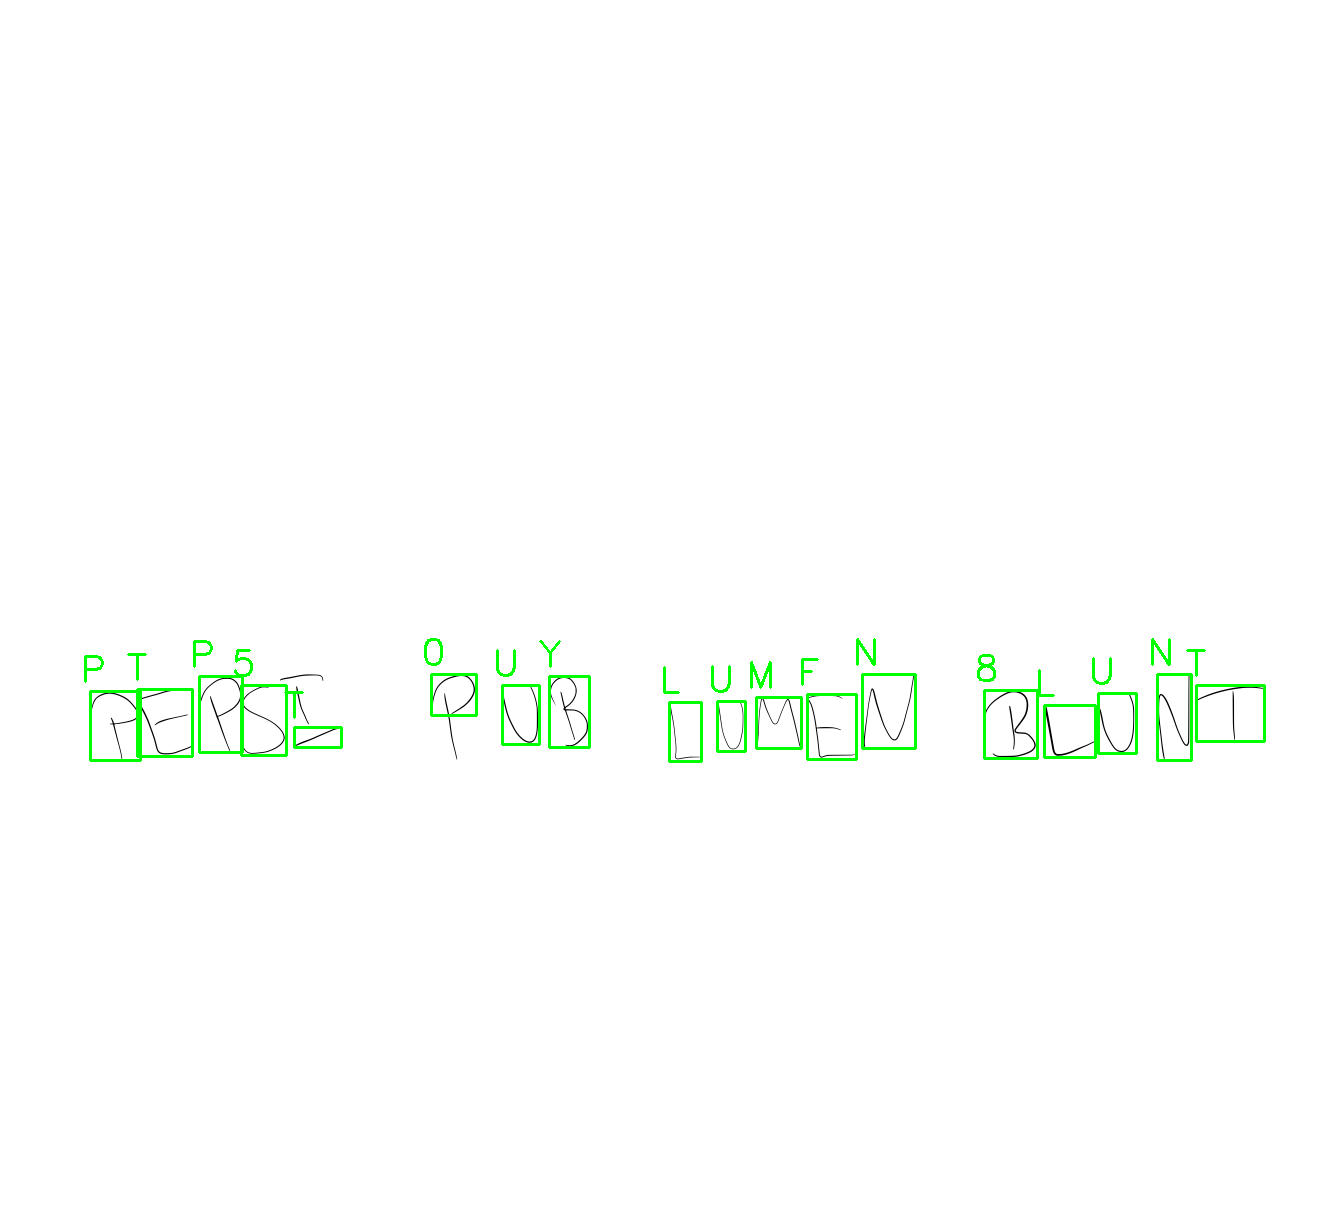

In [18]:
cv2_imshow(image)